In [23]:
import pandas as pd
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
import os
print(torch.__version__)

2.5.1+cu121


In [2]:
# create device agnosticism, but preferably should run on cuda
# I am working with Colab Pro Regular, and will be using the Tesla A100
primary_device = "cuda" if torch.cuda.is_available() else "cpu"
primary_device, torch.cuda.device_count()

('cuda', 1)

In [5]:
# data has been normalized, flattened to two dimensions, and shuffled to make it ready for the ML model
# I am hosting the data on my personal site at the following url:
data_url = 'https://www.tyro.work/cont-us-pop-flattened-250per-shuffled.csv'
# use bash command on colab to get the data from the url
if not os.path.exists('/content/cont-us-pop-flattened-250per-shuffled.csv'):
  !wget $data_url
else:
  print("Flattened Population Data has already been downloaded.")

--2024-11-23 04:14:01--  https://www.tyro.work/cont-us-pop-flattened-250per-shuffled.csv
Resolving www.tyro.work (www.tyro.work)... 162.244.93.7, 2602:faa9:1008:918:fd16:9073:7cff:b175
Connecting to www.tyro.work (www.tyro.work)|162.244.93.7|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 60192732 (57M) [text/csv]
Saving to: ‘cont-us-pop-flattened-250per-shuffled.csv’

cont-us-pop-flatten 100%[===================>]  57.40M  98.7MB/s    in 0.6s    

2024-11-23 04:14:02 (98.7 MB/s) - ‘cont-us-pop-flattened-250per-shuffled.csv’ saved [60192732/60192732]



In [18]:
# use pandas to access the csv we downloaded and turn it into PyTorch tensor
data_frame = pd.read_csv('/content/cont-us-pop-flattened-250per-shuffled.csv')
# convert data frame into a tensor
lat_tensor = torch.tensor(data_frame['lat'].values)
lng_tensor = torch.tensor(data_frame['lng'].values)
# stack the lat and lng tensors vertically to create 2d tensor
# BUT CAREFUL - latitude is how far up and down so it's y axis, lng is left right and it's x axis
lnglat_tensor = torch.vstack((lng_tensor, lat_tensor))
lnglat_tensor, lnglat_tensor.shape, lnglat_tensor[0]
# not sure if data should be represented in rows x columns as parameter x testcase, or testcase x parameter
# we'll come back to that

(tensor([[ 12.4630,  16.5247,  17.6344,  ...,  17.3486, -10.1619, -30.1466],
         [  0.8238,   1.7264,   2.8712,  ...,   2.3788,  -4.6711,   9.2089]],
        dtype=torch.float64),
 torch.Size([2, 1315643]),
 tensor([ 12.4630,  16.5247,  17.6344,  ...,  17.3486, -10.1619, -30.1466],
        dtype=torch.float64))

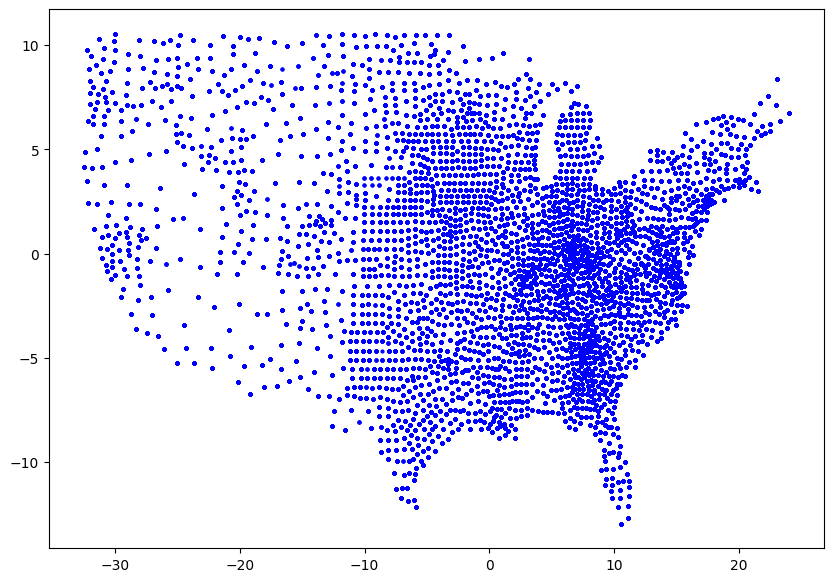

In [19]:
# let's create a plotting device for our data points
def plot_inputs(input_tensor):
  plt.figure(figsize = (10,7))
  plt.scatter(input_tensor[0], input_tensor[1], c='b', s=4, label='data points')

plot_inputs(lnglat_tensor)

County Location Data has already been downloaded.
county data shape:  torch.Size([2, 3109])


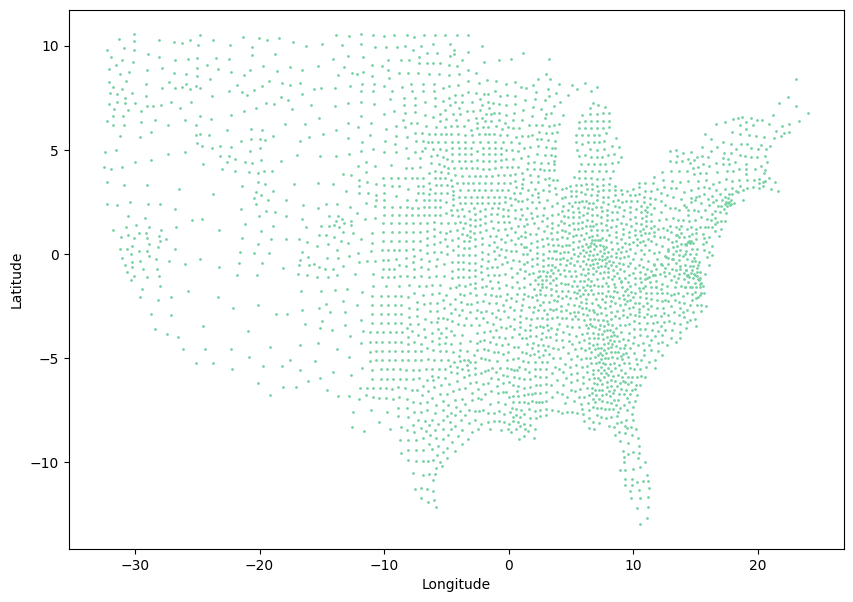

In [110]:
# perfect. so that is great to see that it's working, but we don't need to draw all 1,300,000 points overtop of each other just to show the map.
# so let's import the unflattened data just to display everything with less draw time

# repeat the same steps we did before to format the data
drawing_data = 'https://www.tyro.work/cont-us-counties-latlng-normalized.csv'
if not os.path.exists('/content/cont-us-counties-latlng-normalized.csv'):
  !wget $drawing_data
else:
  print("County Location Data has already been downloaded.")

drawing_df = pd.read_csv('/content/cont-us-counties-latlng-normalized.csv')
draw_lat_tensor = torch.tensor(drawing_df['lat'].values)
draw_lng_tensor = torch.tensor(drawing_df['lng'].values)
draw_lnglat_tensor = torch.vstack((draw_lng_tensor, draw_lat_tensor))
print("county data shape: ", draw_lnglat_tensor.shape)
# these constants will be useful for randomizing our centroids
lat_max = draw_lat_tensor.max().item()
lat_min = draw_lat_tensor.min().item()
lng_max = draw_lng_tensor.max().item()
lng_min = draw_lng_tensor.min().item()

def draw_counties():
  plt.figure(figsize = (10,7))
  plt.scatter(draw_lnglat_tensor[0], draw_lnglat_tensor[1], c='#79d2a4', marker='.', s=4, label='U.S. Counties')
  plt.xlabel('Longitude')
  plt.ylabel('Latitude')

# now we have a method to quickly draw the county locations
draw_counties()

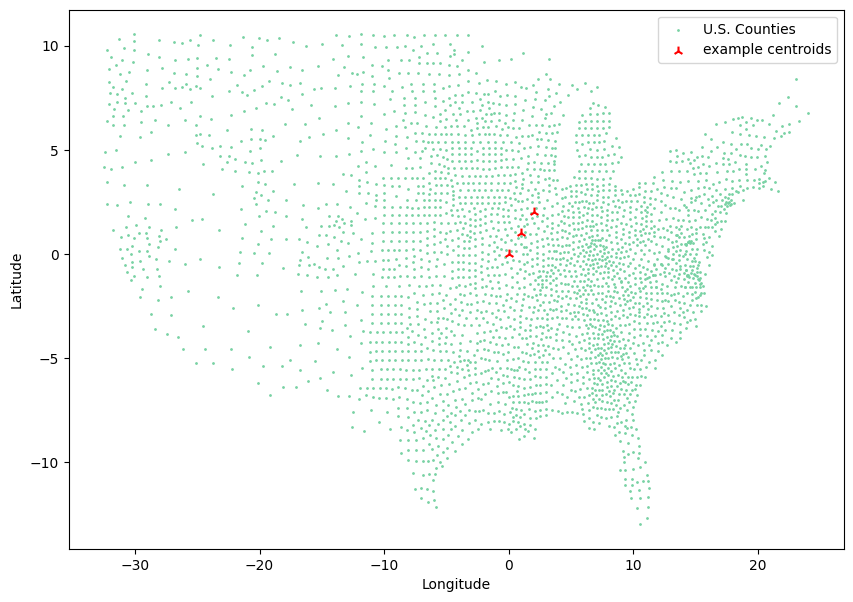

In [111]:
x = [0, 1, 2]
y = [0, 1, 2]
draw_counties()
plt.scatter(x, y, c='r', s=50, marker='2', label='example centroids')
plt.legend()
# just an example of checking to see how our centroids will look over top of the county data

10.544571276937925
24.506700000000002 57.52810000000001 -12.962128723062076 -32.49824203924092
tensor([[ 8.7061, 12.5918,  6.9777, -7.1348, 22.5725],
        [ 4.0748, -5.2187,  9.7863, -9.0209,  2.1002]])


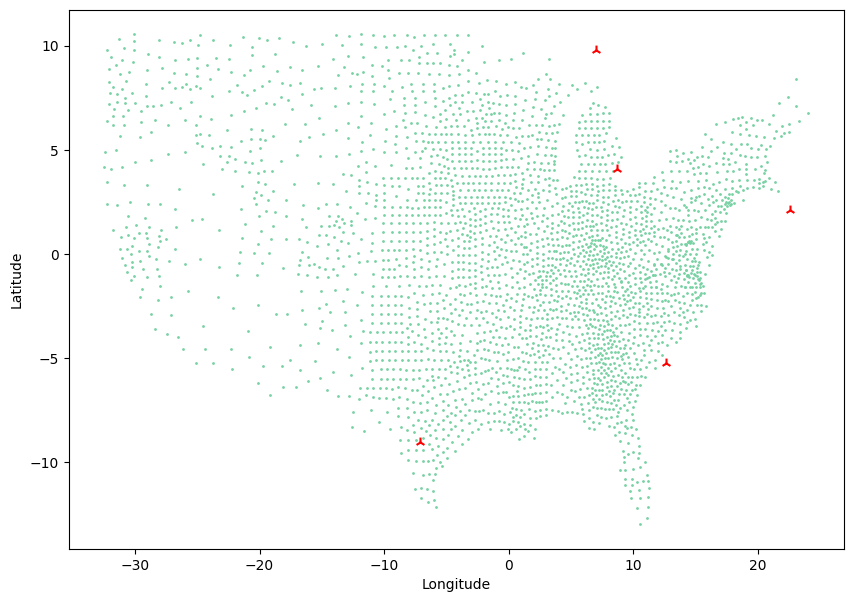

In [130]:
# now it's time to set up our k-means
# we want to pick the number of starting centroids (k), I believe that's our only input variable
print(lat_max)
LAT_RANGE = lat_max - lat_min + 1
LNG_RANGE = lng_max - lng_min + 1
LAT_SHIFT = lat_min # the shifts are negative values, so add them not subtract
LNG_SHIFT = lng_min
def k_means(k):
  # we want to perform 100 different randomizations for the starting points
  for seed in range(100):
    torch.manual_seed(seed)
    centroids = torch.rand(2, k)
    # to turn a range from 0 to 1 into our latitudes and longitudes we can:
    # multiply the random by the range, and then shift by the minimum
    centroids[0] = centroids[0] * LNG_RANGE + LNG_SHIFT
    centroids[1] = centroids[1] * LAT_RANGE + LAT_SHIFT
    print(centroids)
    draw_counties()
    plt.scatter(centroids[0], centroids[1], c='r', s=50, marker='2', label='example centroids')

print(LAT_RANGE, LNG_RANGE, LAT_SHIFT, LNG_SHIFT)
k_means(5)

tensor([[0.4963, 0.7682, 0.0885, 0.1320, 0.3074],
        [0.6341, 0.4901, 0.8964, 0.4556, 0.6323]])
